In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

while 'jupyter' in os.getcwd():
    os.chdir("../")

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/msat/projects/white-box-nn


In [3]:
import torch
from torch import einsum, nn

import pandas as pd
import seaborn as sn
import numpy as np
import math
import random
import cv2
import matplotlib.pyplot as plt

from art.attacks.evasion import FastGradientMethod, AutoAttack, AutoProjectedGradientDescent, SquareAttack, BoundaryAttack
from art.estimators.classification import PyTorchClassifier

from lib.datamodules import MNISTDataModule
from lib.helpers import hh

from lib.modules.sf_model import get_model, visualize_processing_steps


BATCH_SIZE = 200

# LABELS = None
LABELS = [3, 5]
N_CLASSES = len(LABELS) if LABELS else 10

prefix = "mnist"
IMG_SHAPE = (1, 28, 28)
EPS = 0.3
STEP_SIZE = 0.1

VERSION = 0
MODEL_SAVE_PATH = f"models/{prefix}/wbnn_state_dict_{VERSION}.pt"

torch.set_printoptions(linewidth=100)

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [4]:
datamodule = MNISTDataModule(batch_size=BATCH_SIZE, labels=LABELS, shape=IMG_SHAPE[1:])

datamodule.prepare_data()
datamodule.setup()

In [5]:
x_test_all, y_test_all = next(iter(datamodule.test_dataloader(len(datamodule.mnist_test))))
x_test, y_test = x_test_all[:48], y_test_all[:48]
x_test_small, y_test_small = x_test_all[32:48], y_test_all[32:48]

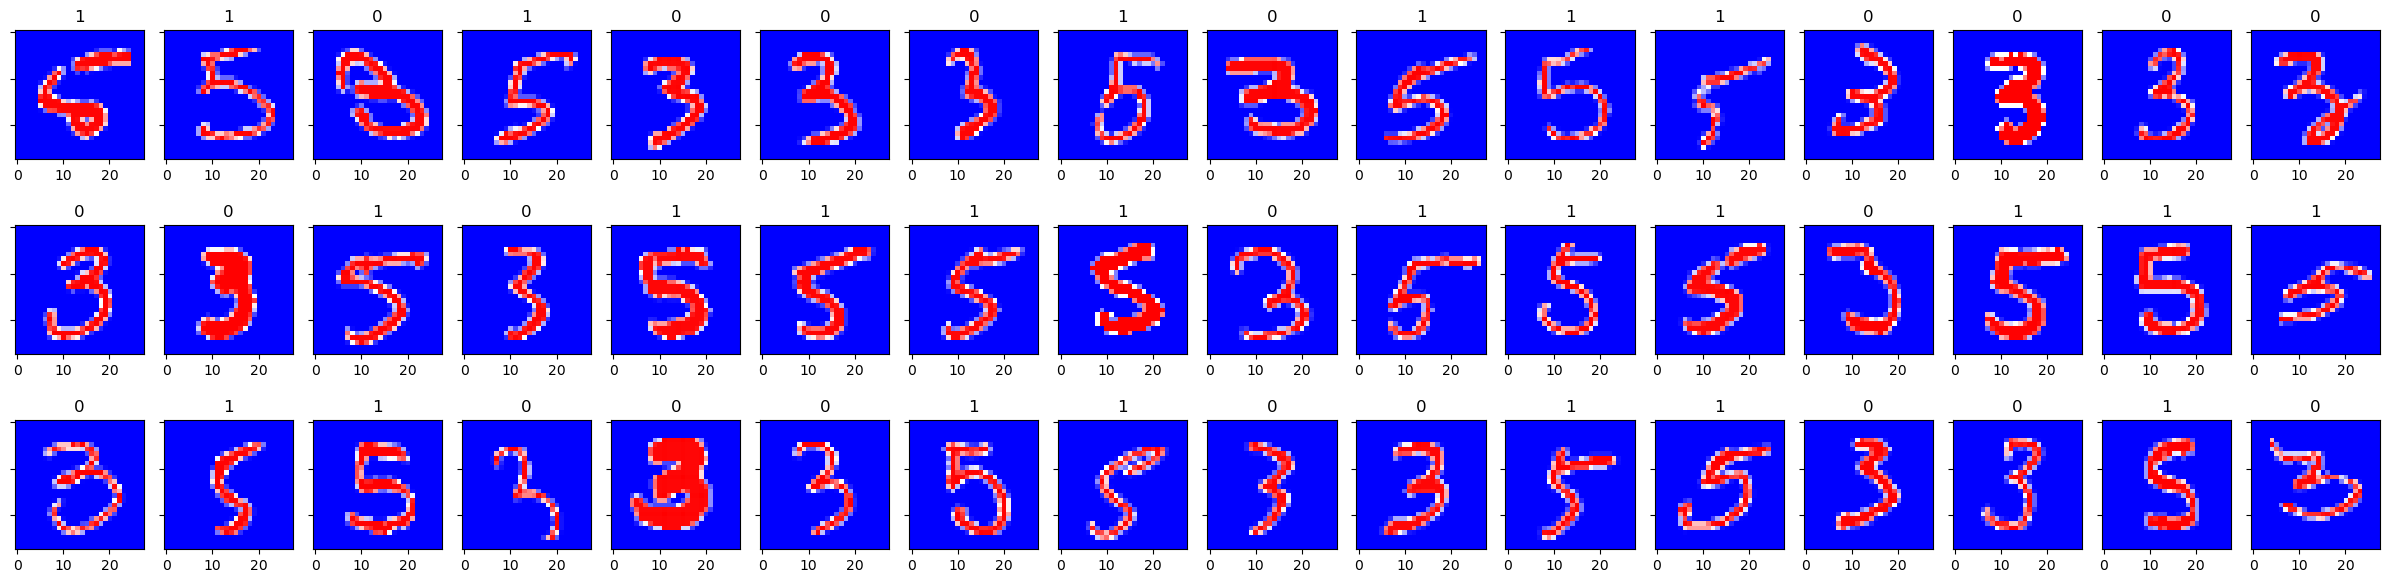

In [6]:
hh.plot_example(x_test, y_test)

# Load model

In [7]:
model = get_model()

save_path = MODEL_SAVE_PATH
model_state_dict = torch.load(save_path, map_location=device)
model.load_state_dict(model_state_dict)
model.eval()
model.training

False

# Attack

In [9]:
def get_classifier(model):
    return PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=None,
        input_shape=IMG_SHAPE,
        nb_classes=N_CLASSES,
    )
    
def perform_attack(classifier, attack, x_test, y_test):
    x_test_adv = torch.from_numpy(attack.generate(x=x_test.cpu().numpy()))

    predictions = classifier.predict(x_test.cpu())
    correct = np.argmax(predictions, axis=1) == y_test.numpy()
    accuracy = np.sum(correct) / len(y_test)
    print("Accuracy on clean test examples: {}%".format(accuracy * 100))

    predictions_adv = classifier.predict(x_test_adv)
    correct_adv = np.argmax(predictions_adv, axis=1) == y_test.numpy()
    accuracy_adv = np.sum(correct & correct_adv) / len(y_test)
    print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

    y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1)))

    return x_test_adv, y_tests

## Quick attacks on small subset

### FGSM

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 97.91666666666666%


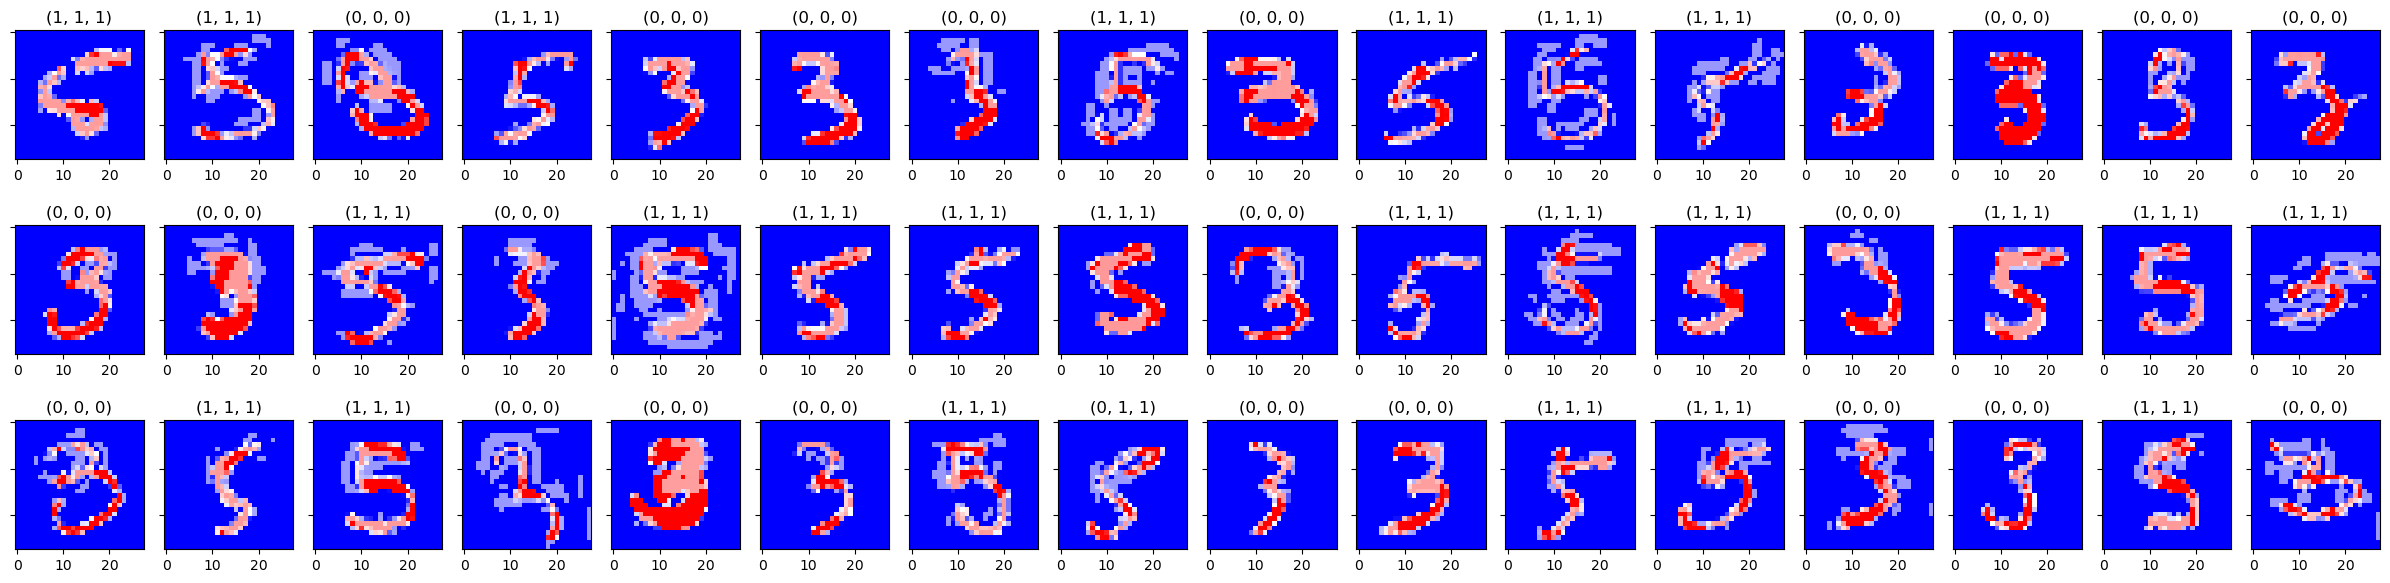

In [10]:
classifier = get_classifier(model)
attack = FastGradientMethod(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

### AutoPGD

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 93.75%


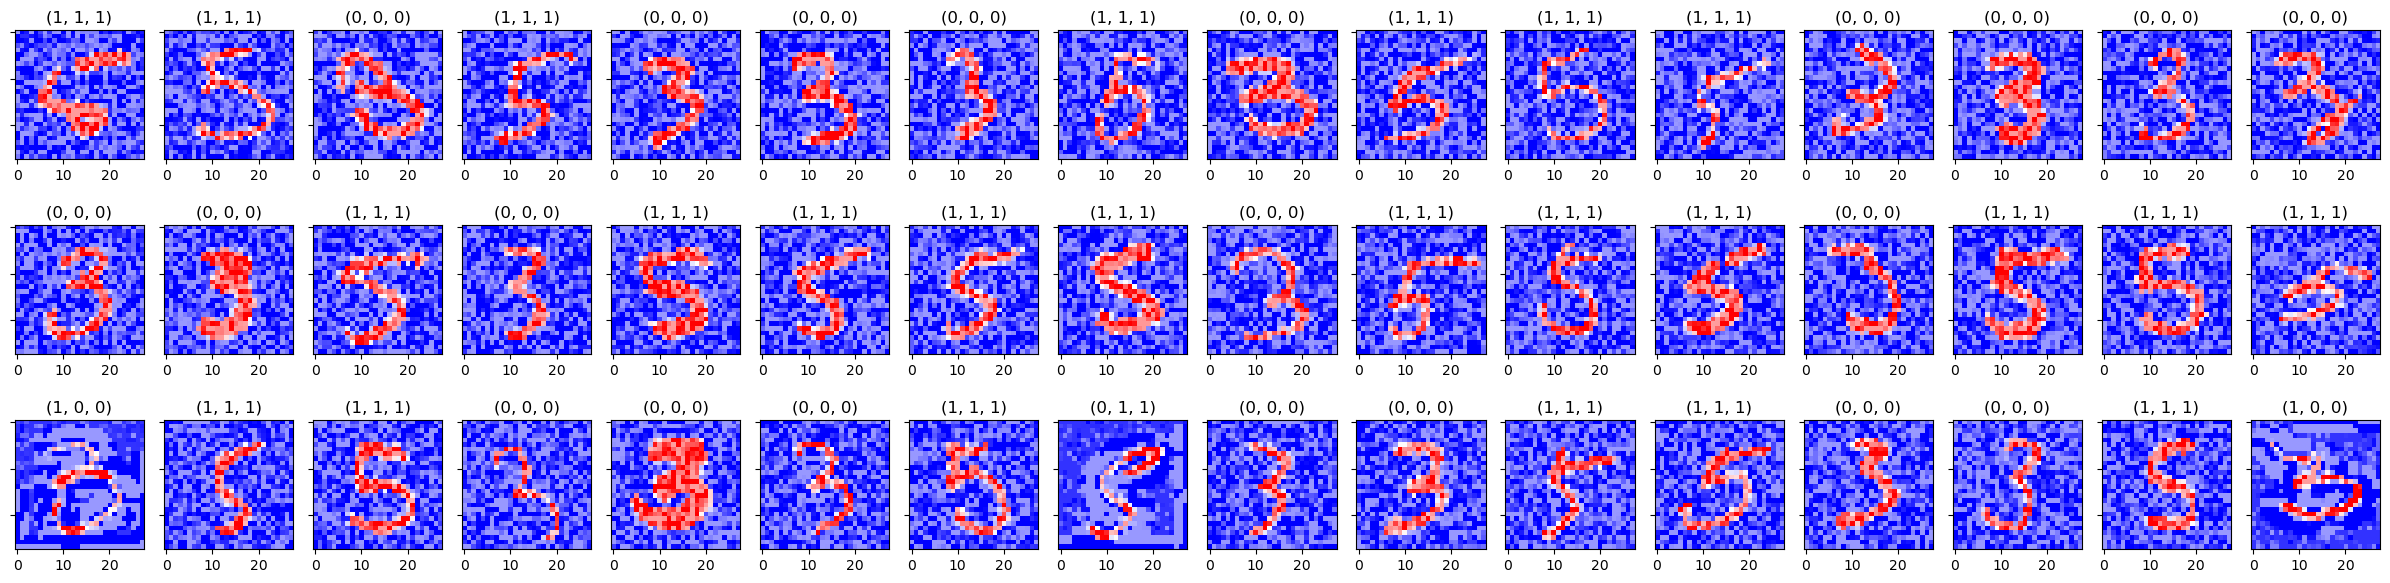

In [11]:
classifier = get_classifier(model)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

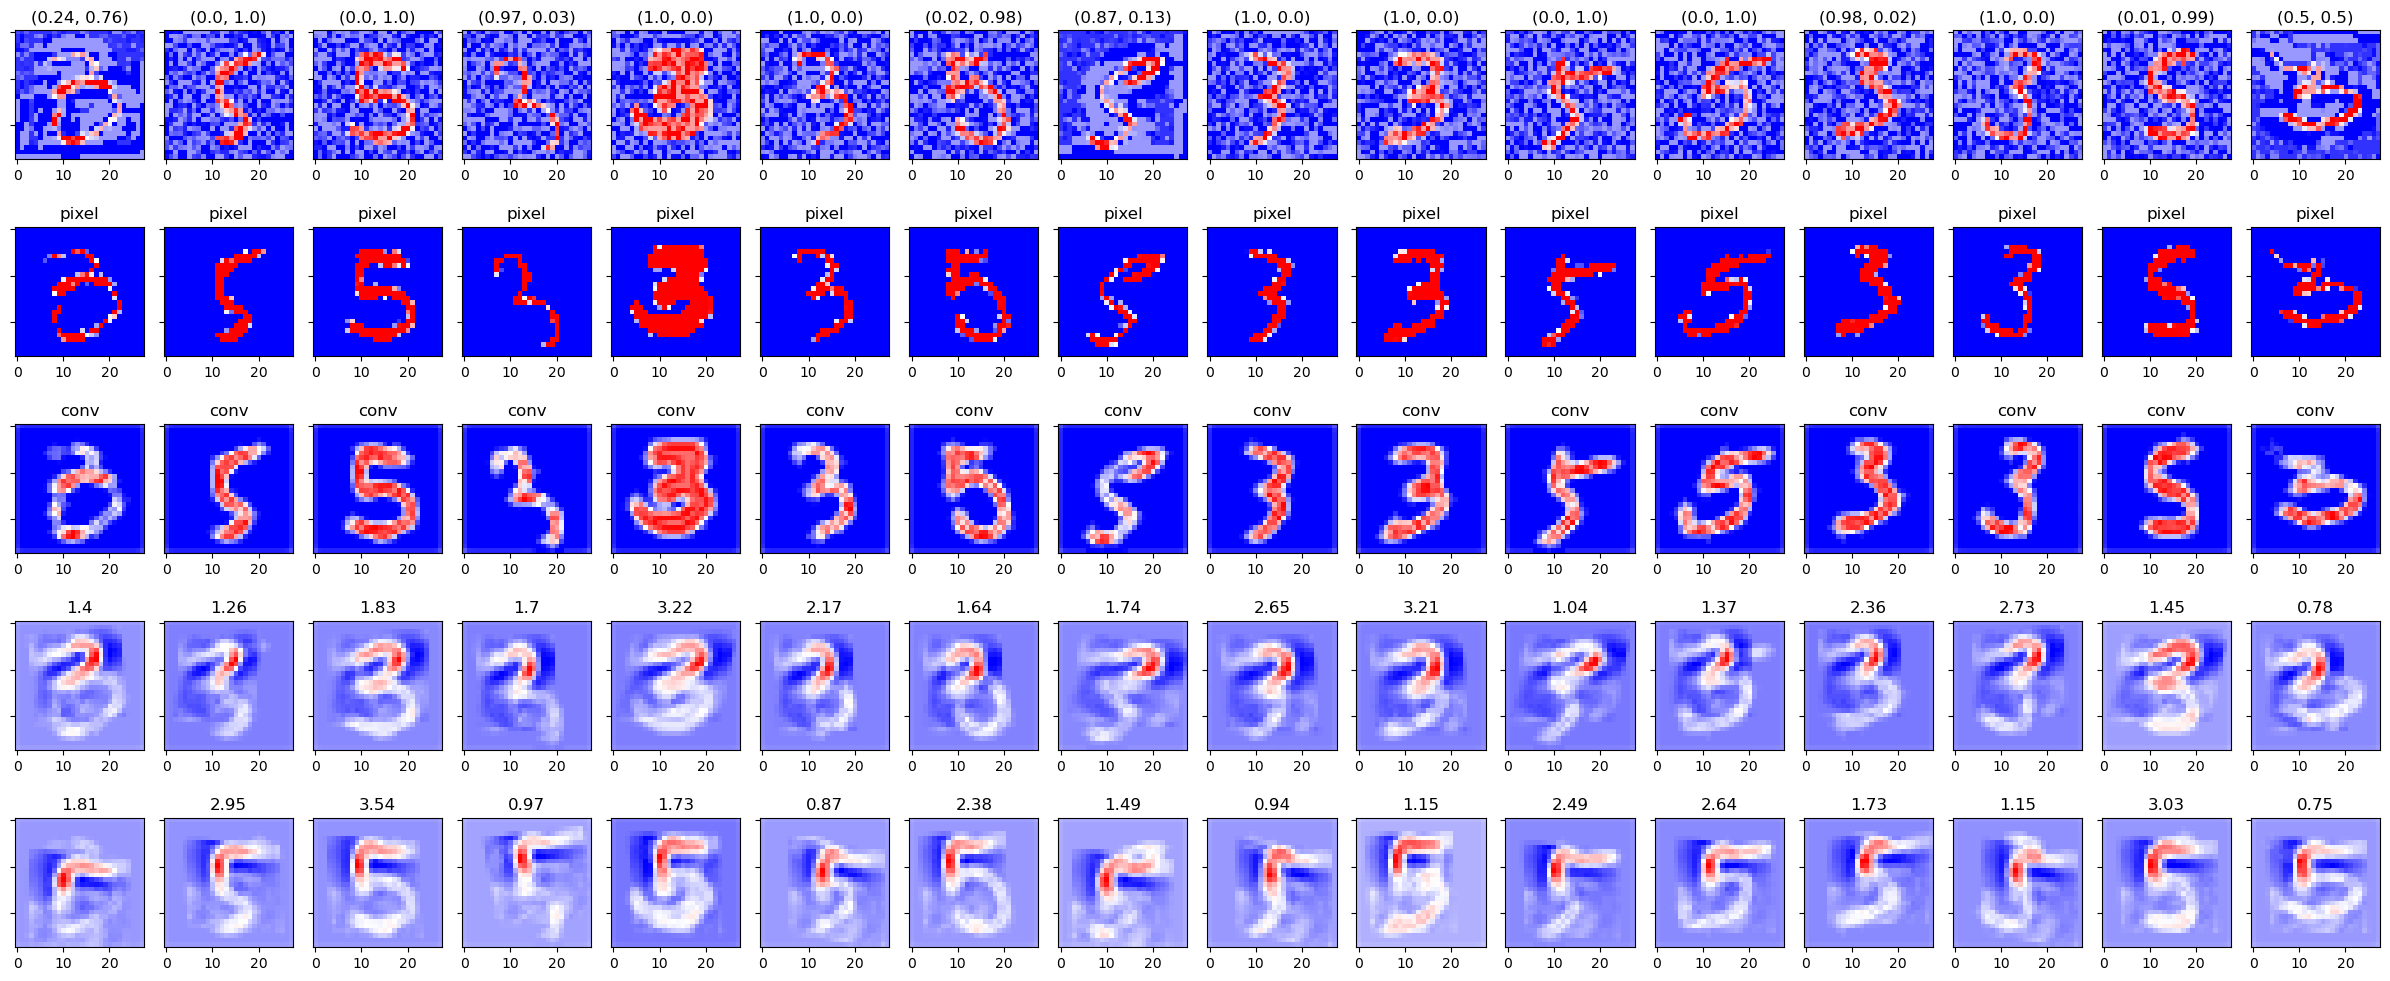

In [12]:
xx = x_test_adv[32:48]
layer_vis, labels = visualize_processing_steps(model, xx)

hh.plot_example(layer_vis, y=labels, n_row=5)

### AutoPGD DLR loss

In [14]:
class DLRAdapter(nn.Module):
    # DLR loss requires at least 3 labels so we add a dummy label to the output
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        x = self.model(x)
        x = torch.cat([x, -100*torch.ones_like(x)[:, :1]], dim=1)
        return x

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 95.83333333333334%


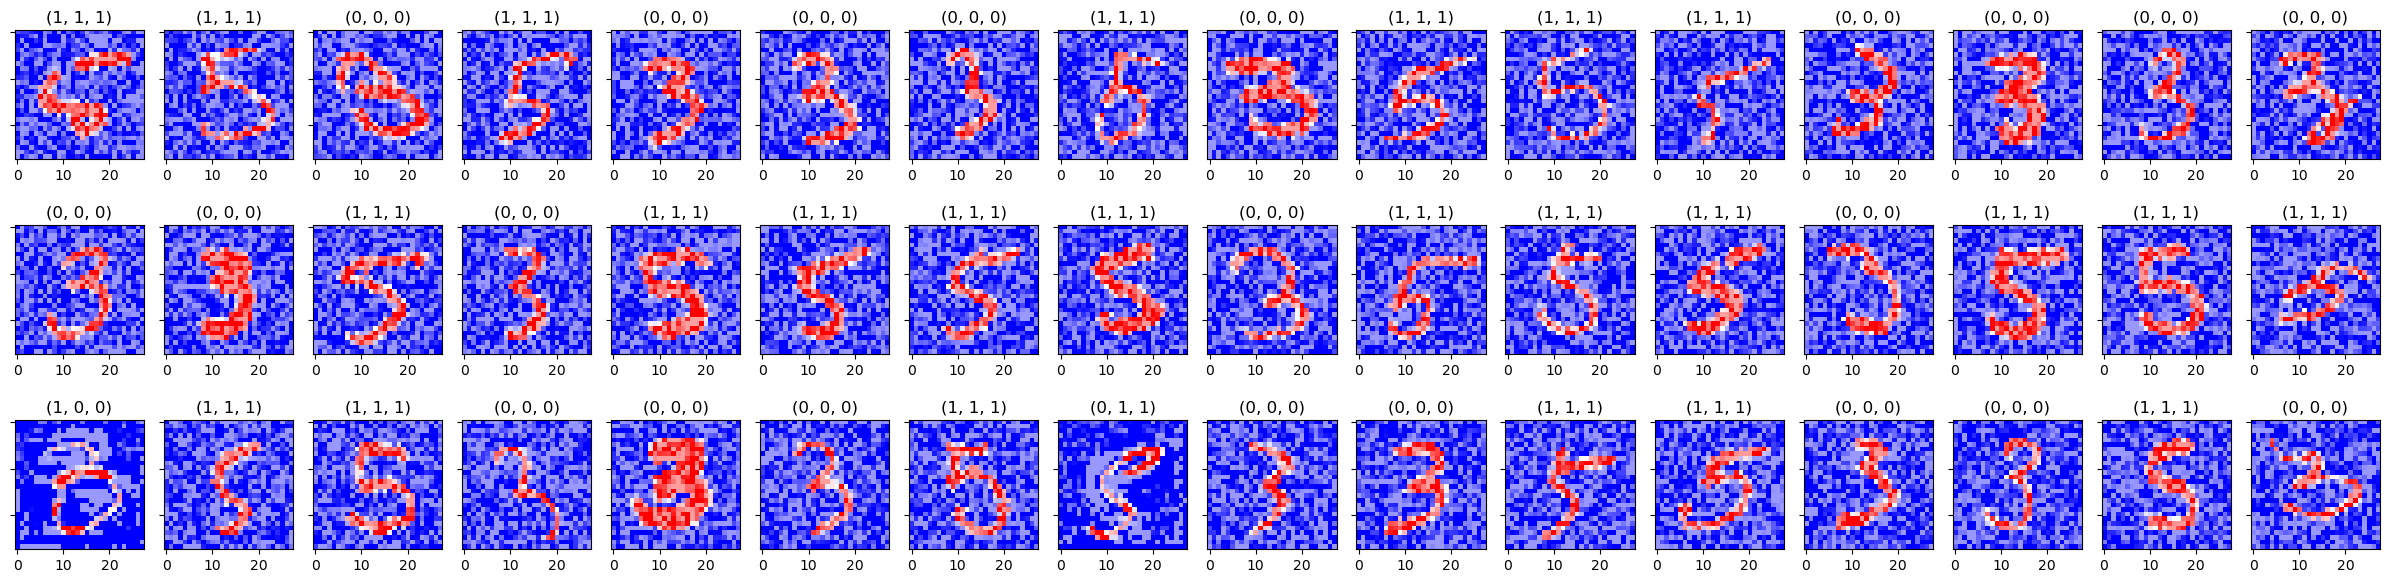

In [15]:
adapted_model = DLRAdapter(model)

classifier = get_classifier(adapted_model)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE, loss_type="difference_logits_ratio")
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

## Slow attacks on tiny subset

### Square attack

SquareAttack - restarts:   0%|          | 0/5 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 81.25%


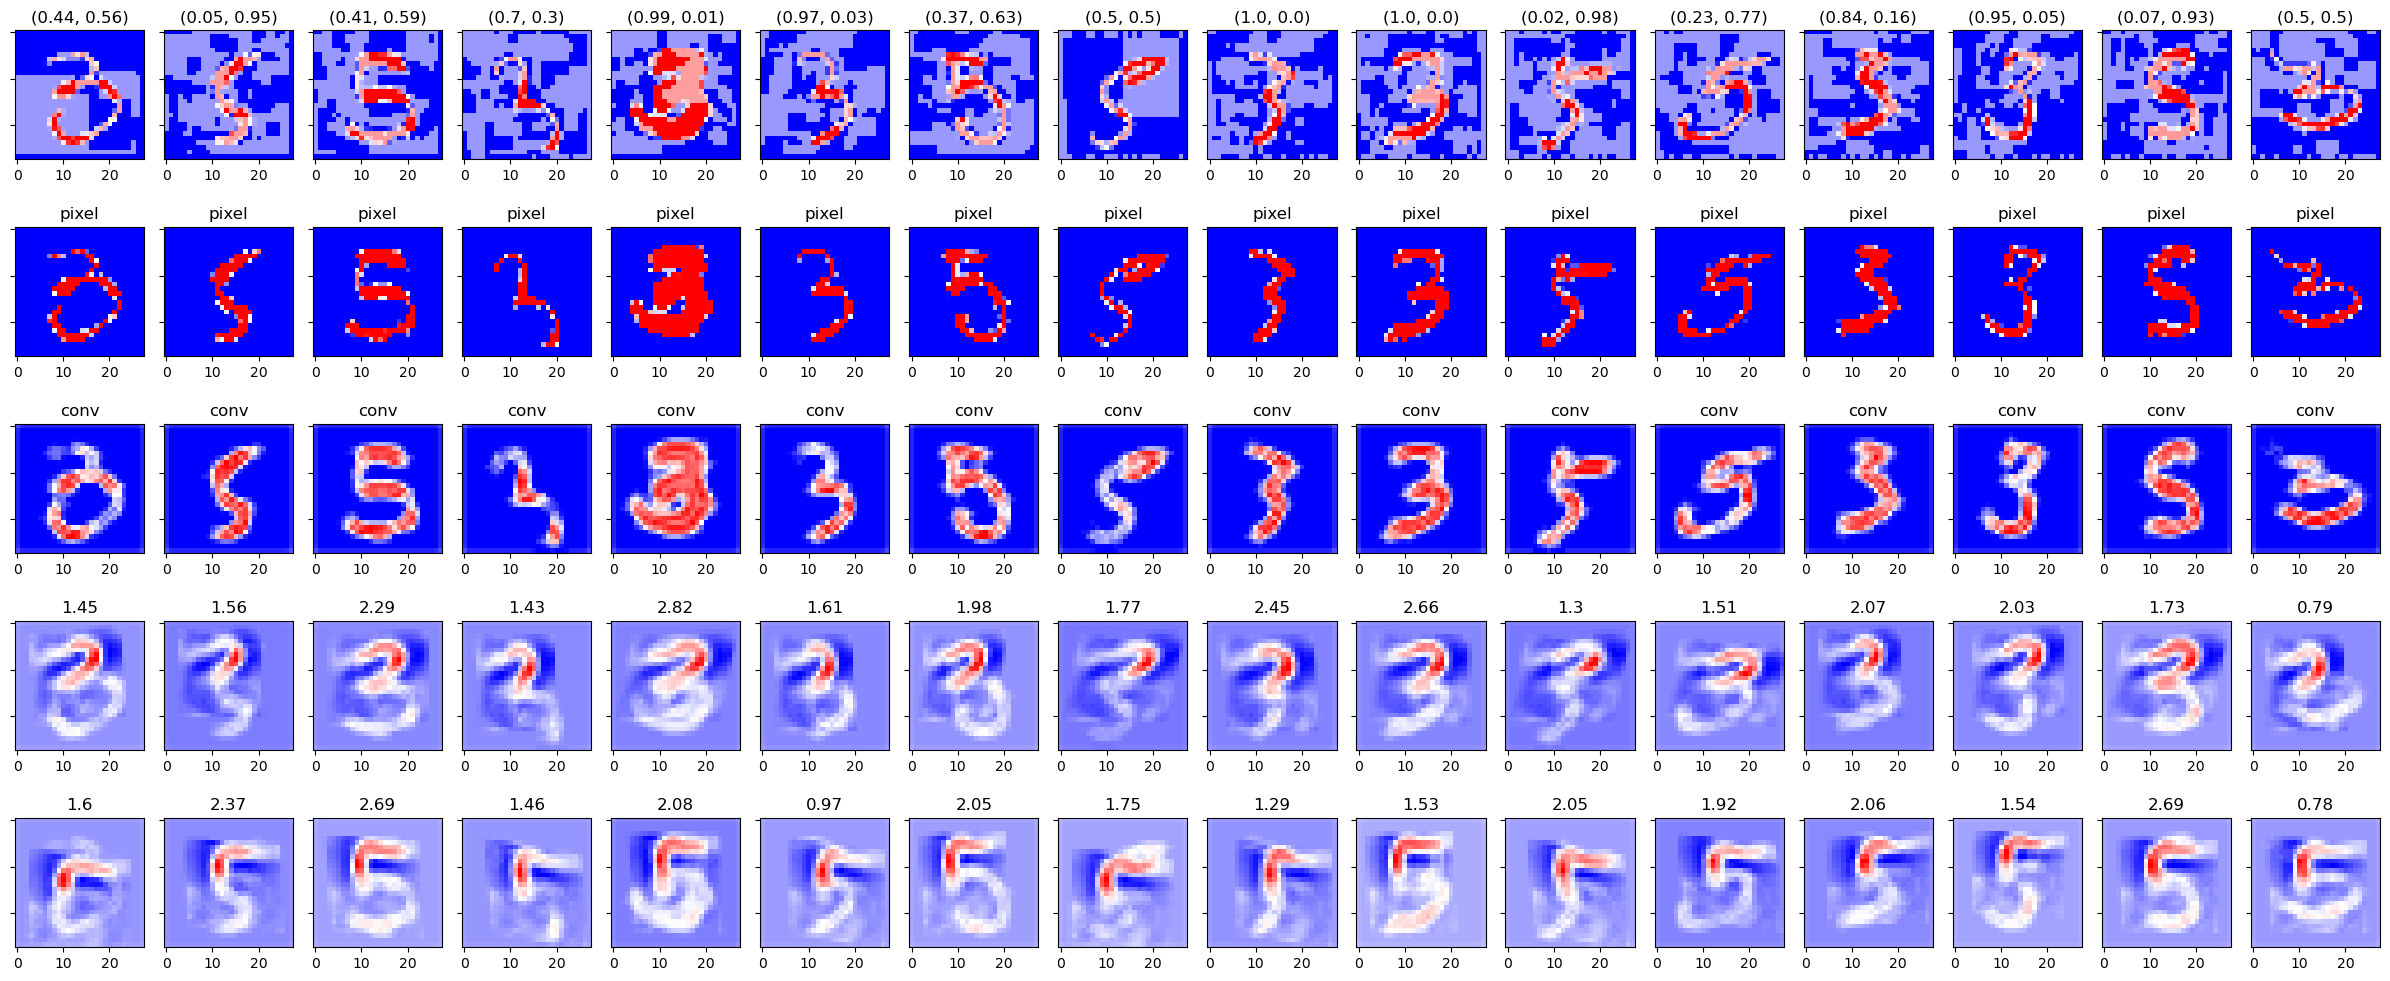

In [16]:
classifier = get_classifier(model)
attack = SquareAttack(estimator=classifier, norm=np.inf, max_iter=5000, eps=EPS, p_init=0.8, nb_restarts=5)
x_test_adv_square, y_tests_square = perform_attack(classifier, attack, x_test_small, y_test_small)

xx = x_test_adv_square
layer_vis, labels = visualize_processing_steps(model, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

### Boundary attack

Boundary attack:   0%|          | 0/16 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 0.0%


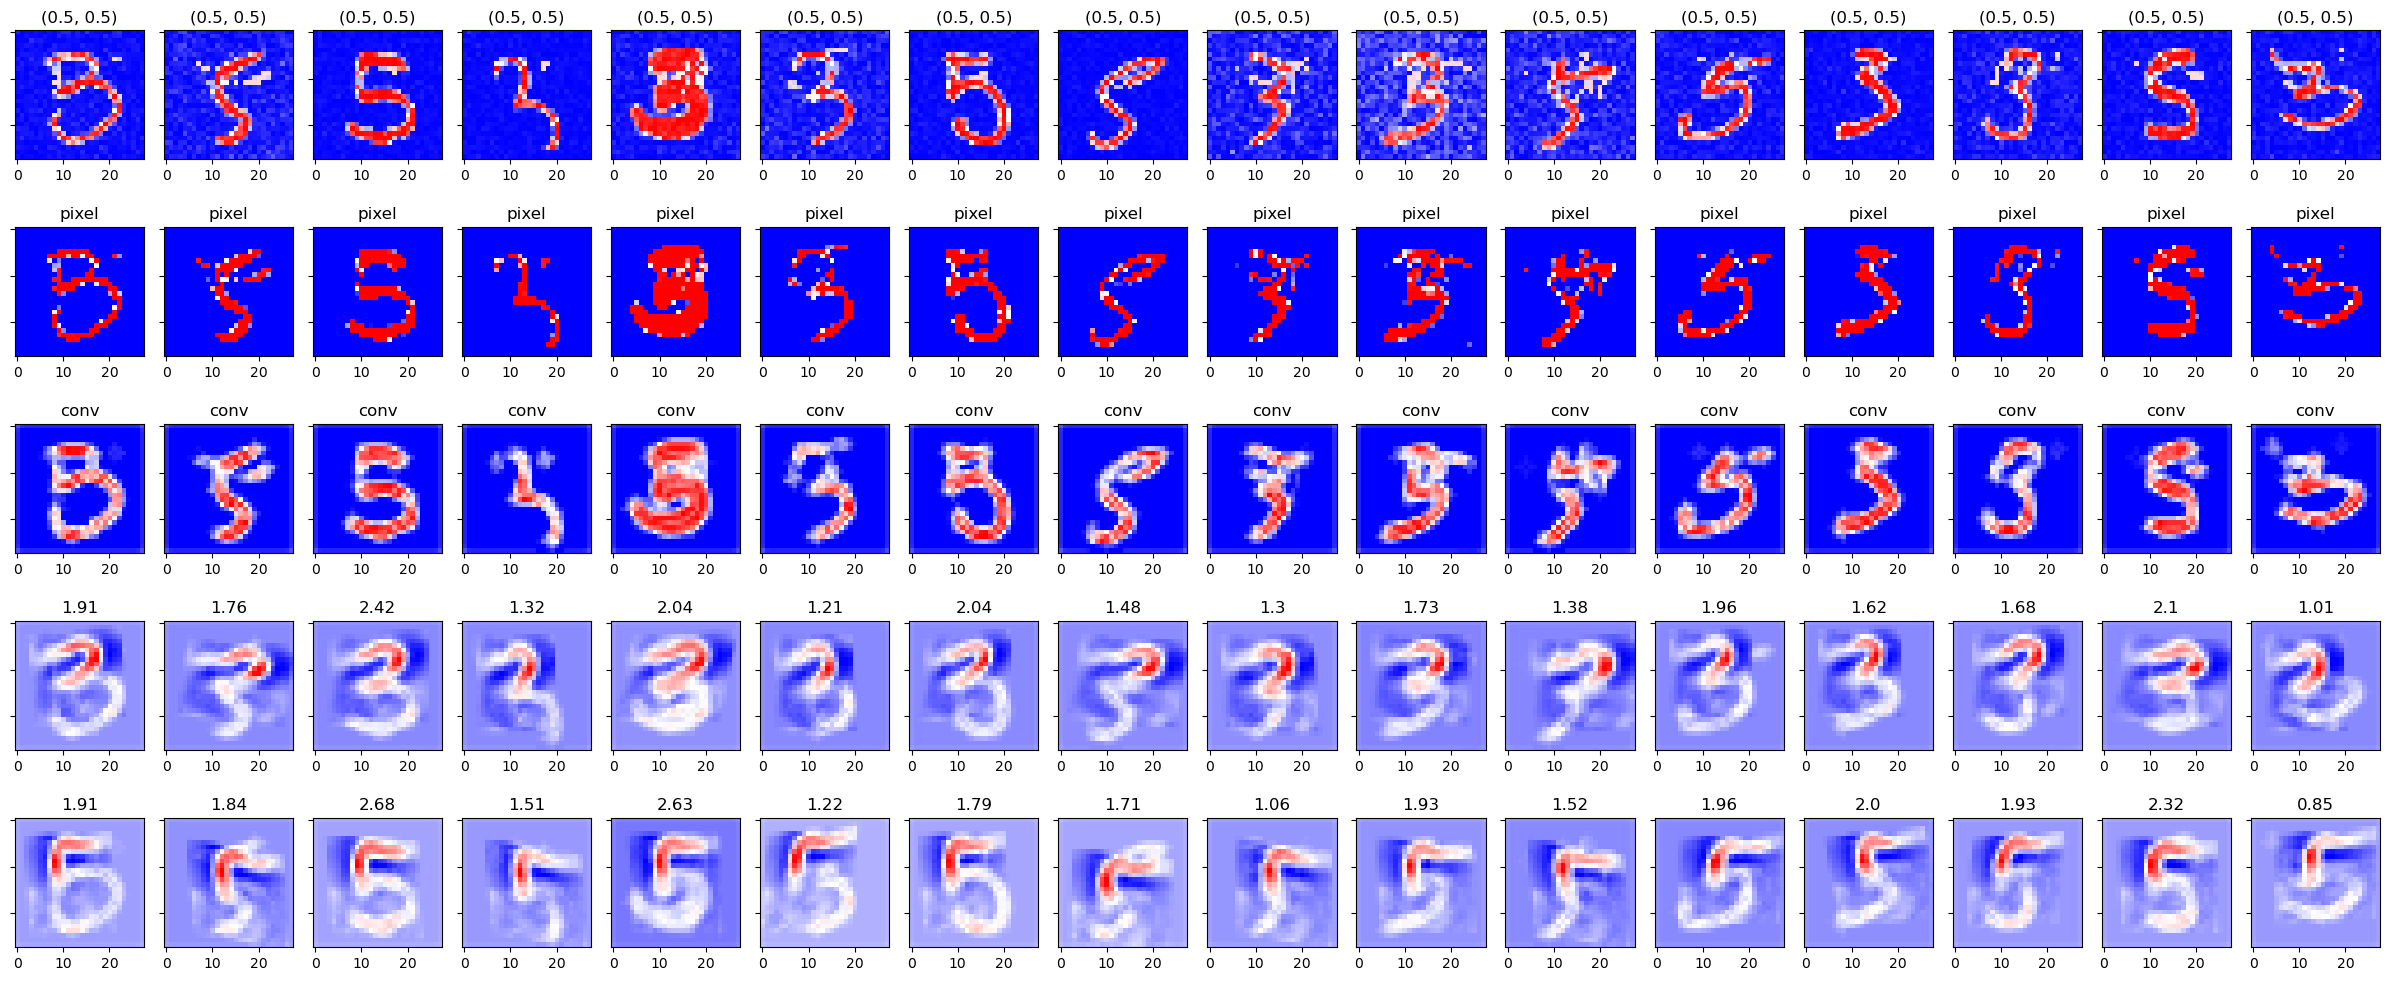

In [17]:
classifier = get_classifier(model)
attack = BoundaryAttack(estimator=classifier, targeted=False, min_epsilon=0.0, max_iter=1000)
x_test_adv_boundary_small, y_tests_boundary_small = perform_attack(classifier, attack, x_test_small, y_test_small)

xx = x_test_adv_boundary_small
layer_vis, labels = visualize_processing_steps(model, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

## Attacks on full test

### AutoAttack

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy on clean test examples: 99.36908517350159%
Accuracy on adversarial test examples: 89.43217665615141%


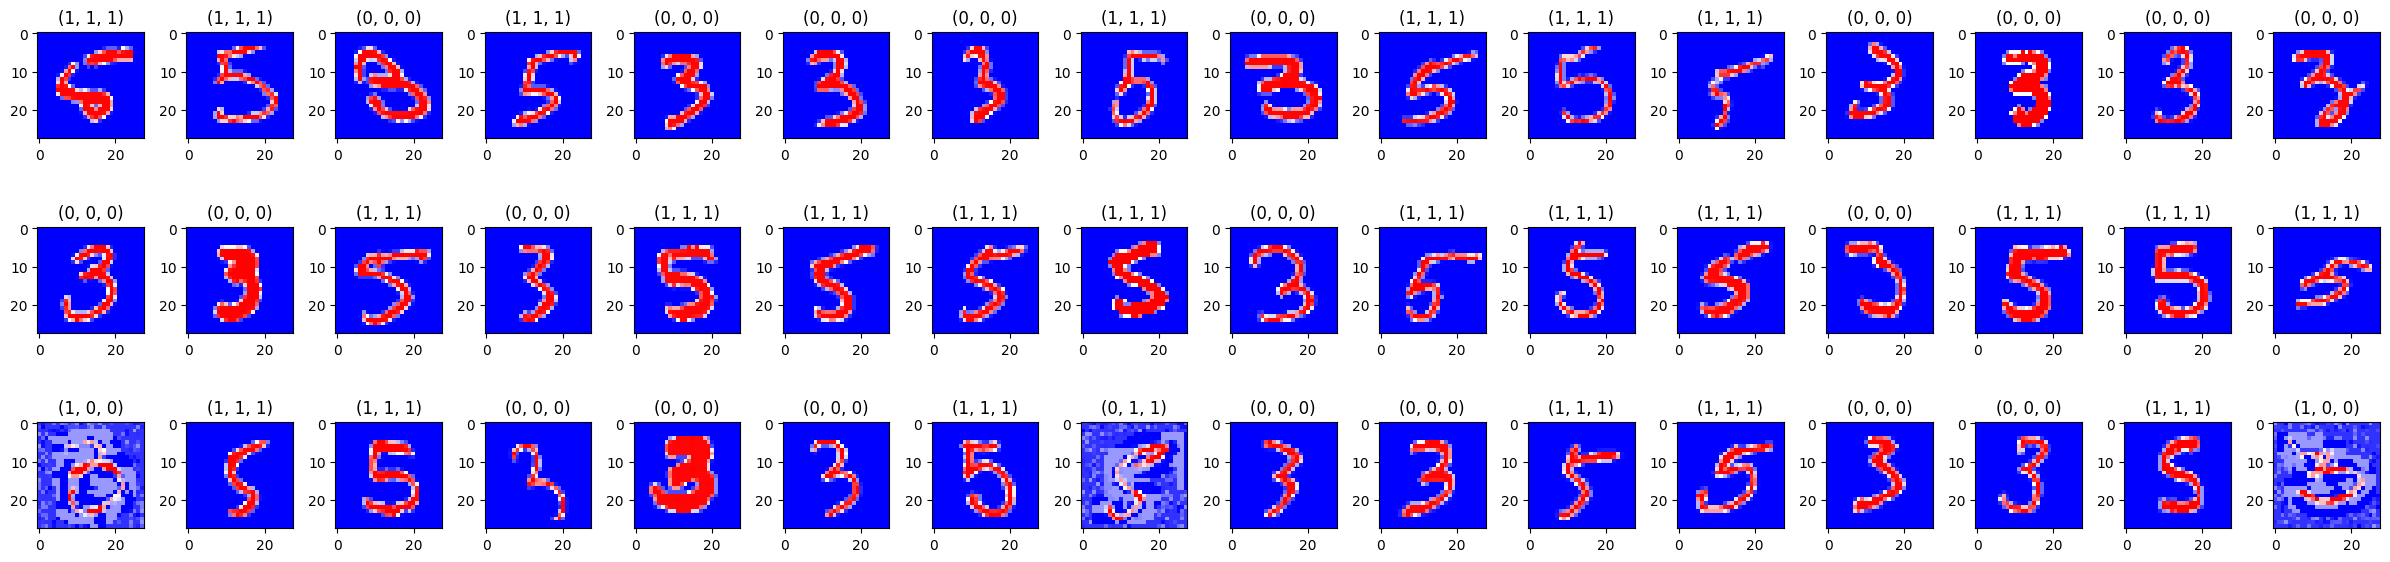

In [211]:
adapted_model = DLRAdapter(model)

classifier = get_classifier(adapted_model)
attack = AutoAttack(estimator=classifier, eps=EPS, eps_step=STEP_SIZE, batch_size=2000)
x_test_adv_all, y_tests_all = perform_attack(classifier, attack, x_test_all, y_test_all)

hh.plot_example(x_test_adv_all, y_tests_all)

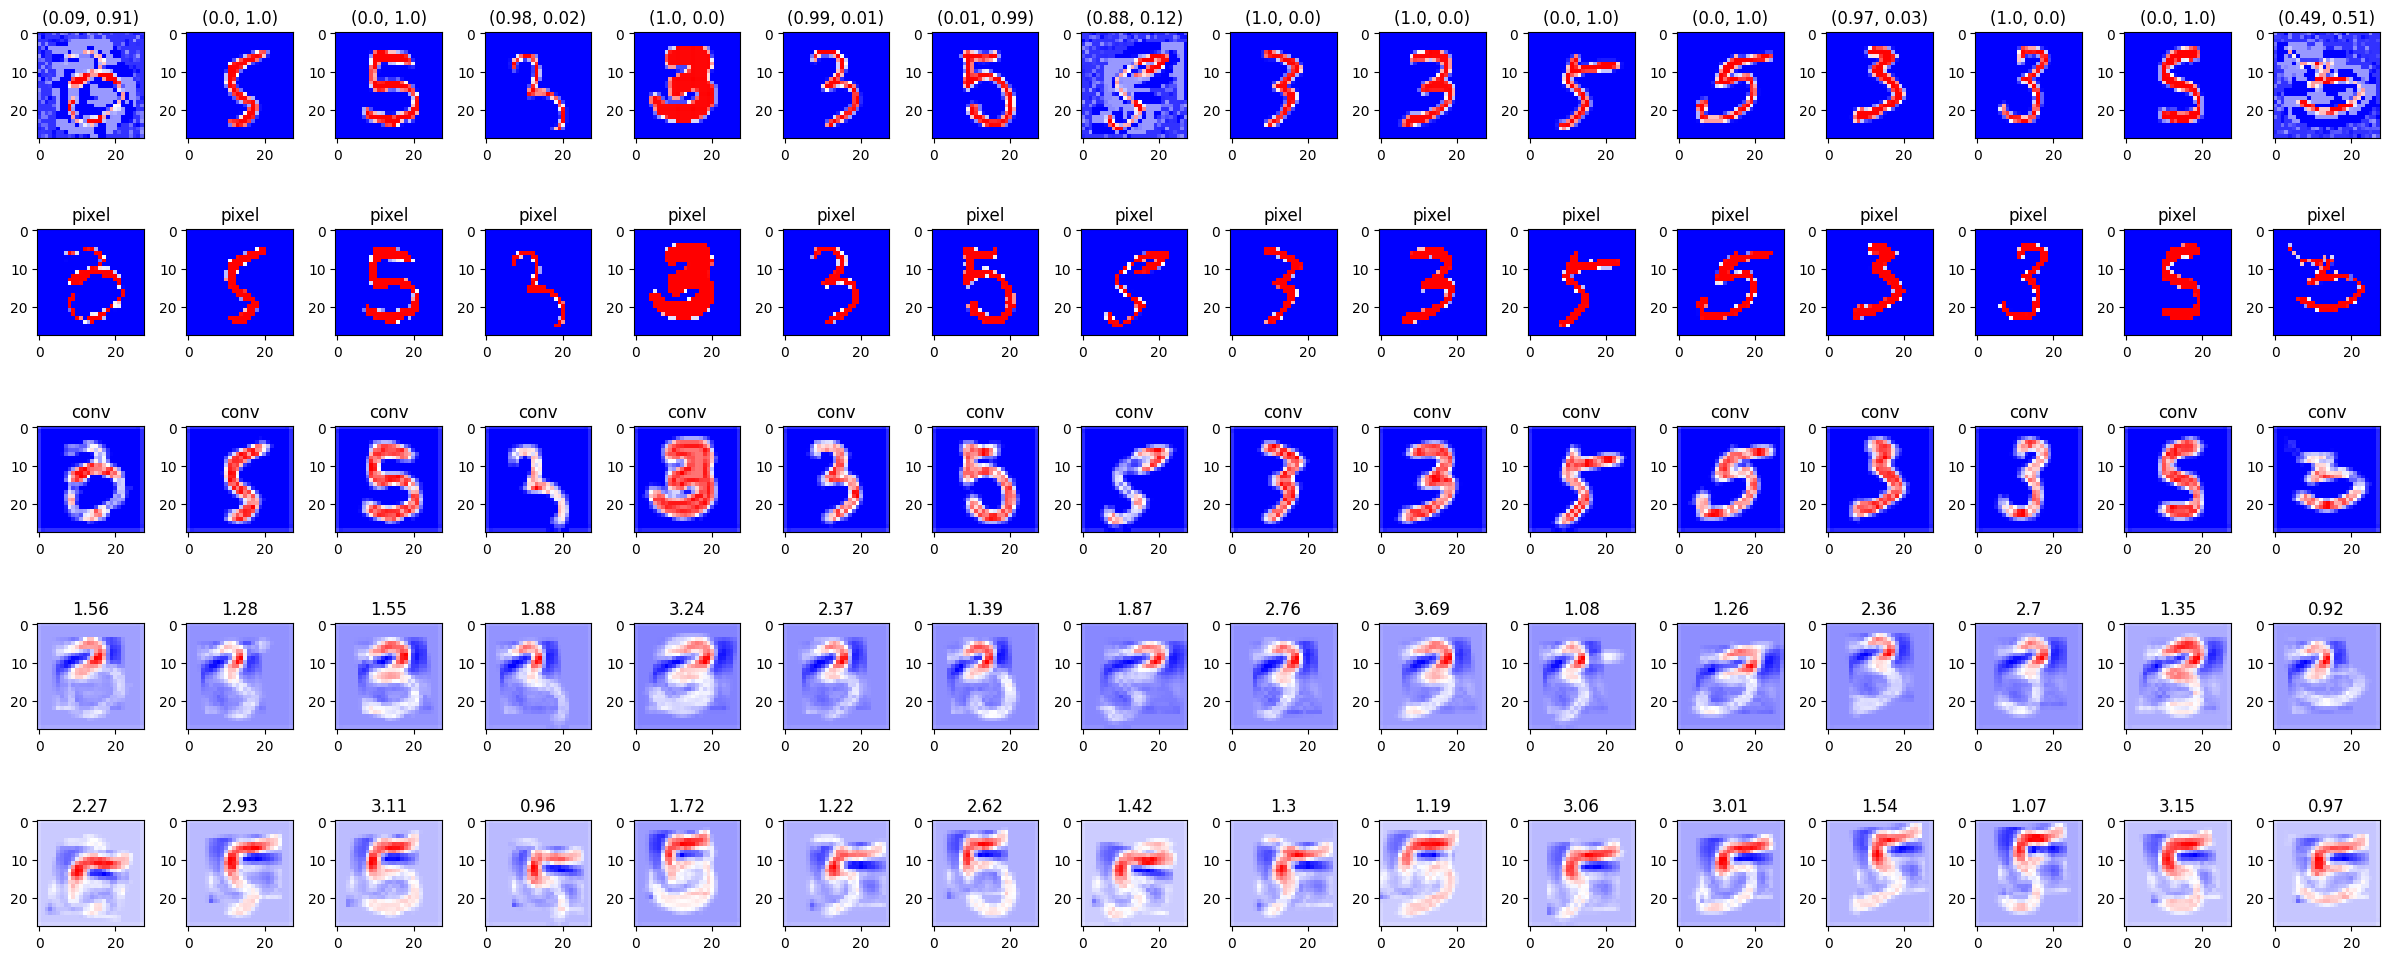

In [56]:
xx = x_test_adv_all[32:48]
layer_vis, labels = visualize_processing_steps(model, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

### AutoPGD on full test - sanity check

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/60 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on clean test examples: 99.36908517350159%
Accuracy on adversarial test examples: 89.95793901156676%


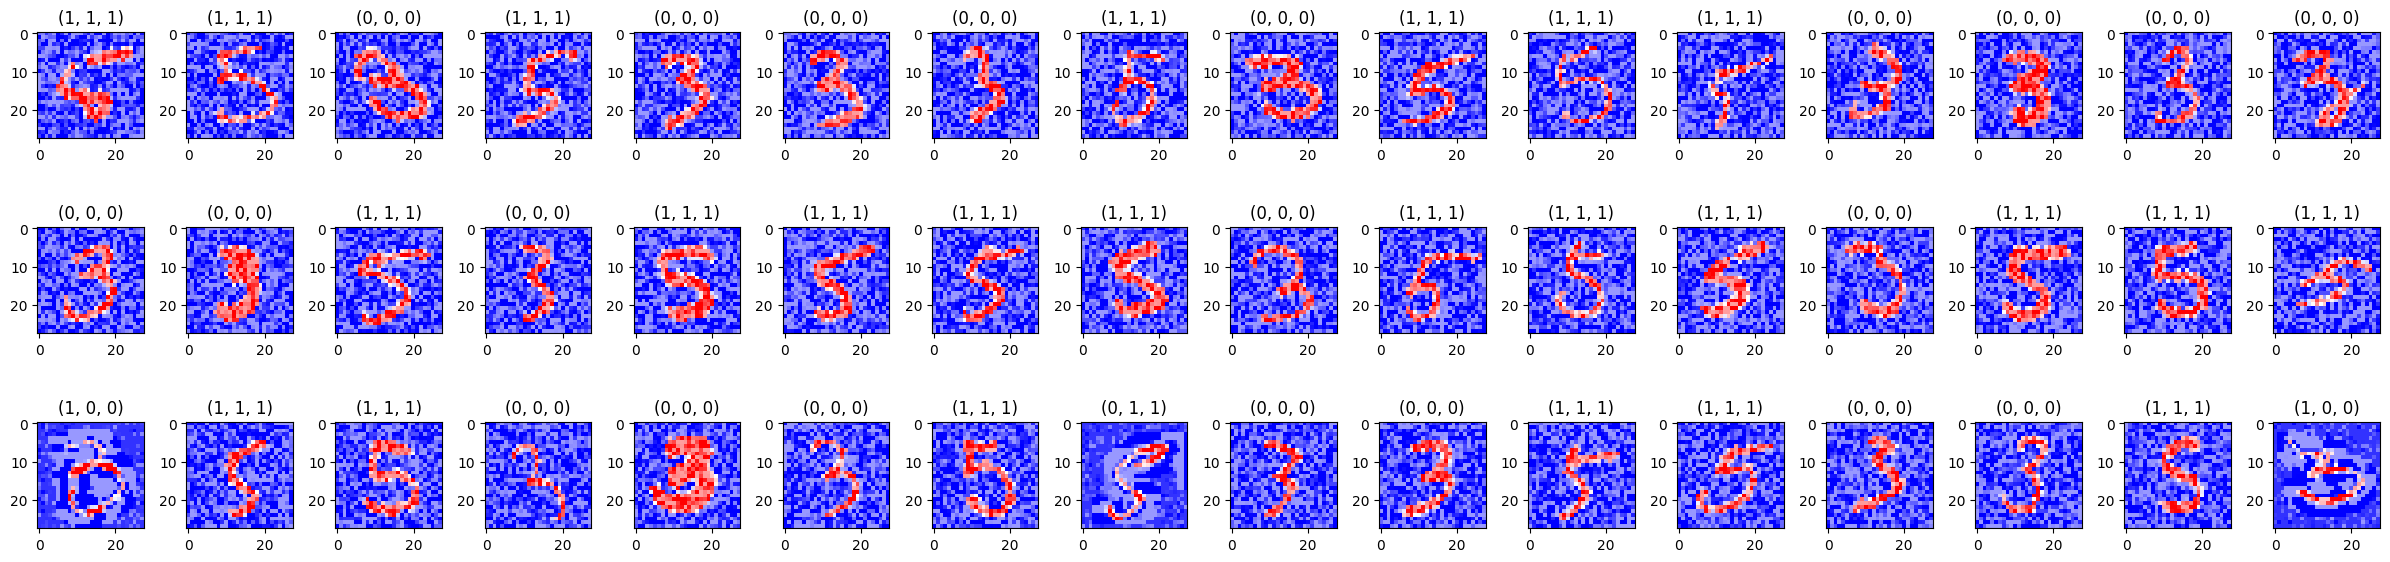

In [58]:
classifier = get_classifier(model)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv_pgd_all, y_tests_pgd_all = perform_attack(classifier, attack, x_test_all, y_test_all)

hh.plot_example(x_test_adv_pgd_all, y_tests_pgd_all)

### Boundary attack - more examples

Boundary attack:   0%|          | 0/48 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 0.0%


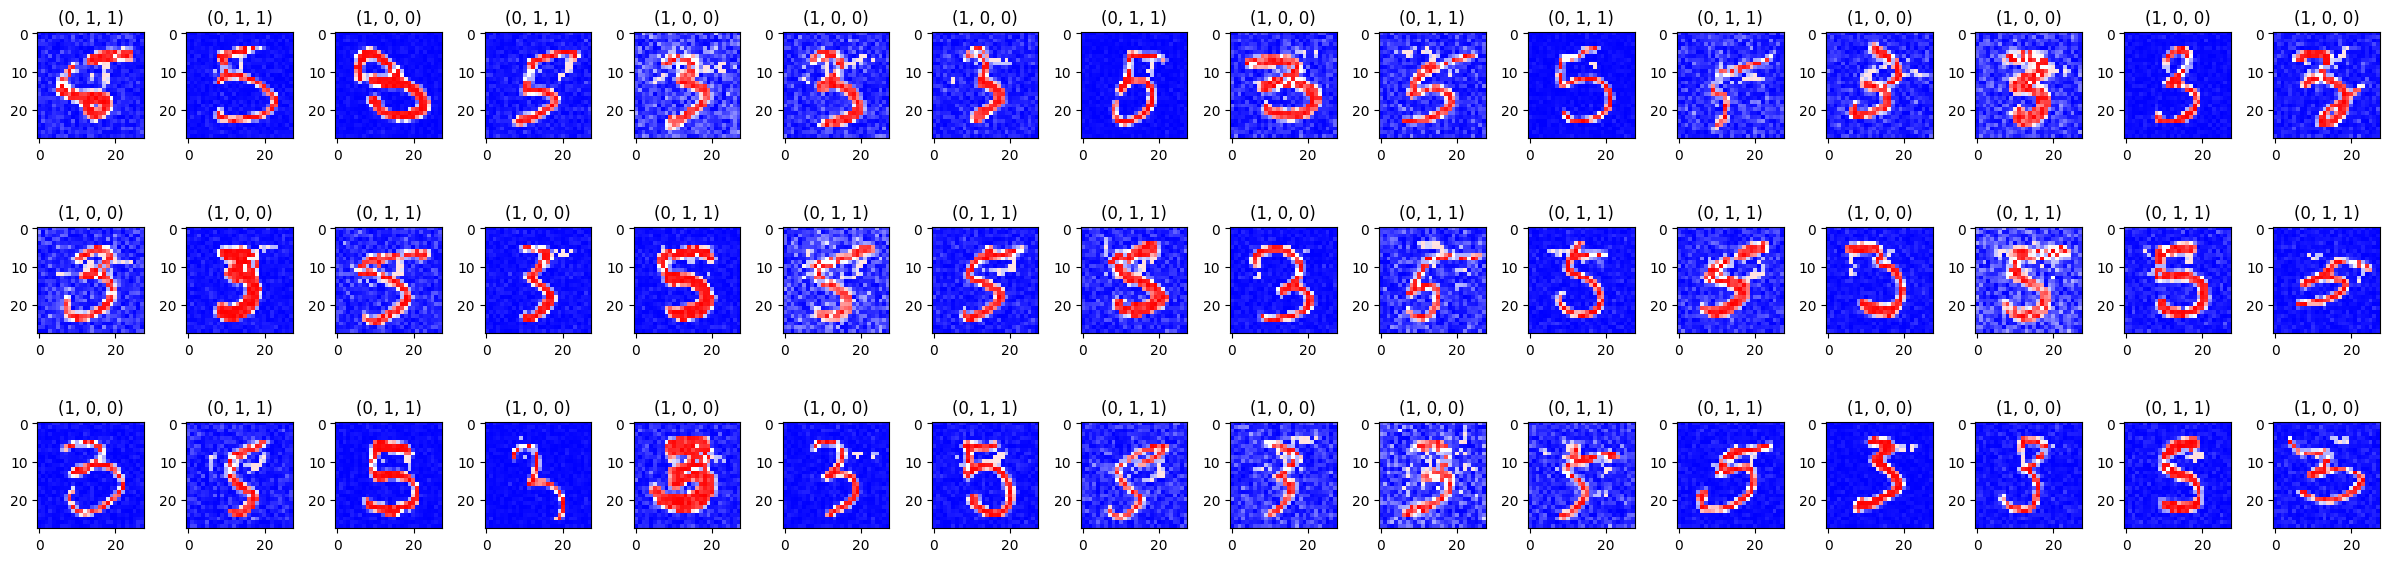

In [62]:
classifier = get_classifier(model)
attack = BoundaryAttack(estimator=classifier, targeted=False, min_epsilon=0.0, max_iter=1000)
x_test_adv_boundary, y_tests_boundary = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv_boundary, y=y_tests_boundary, n_row=3)